In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.div import GainesDiv
from UnarySim.sw.bitstream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time
import math
import numpy as np

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
rng = "Sobol"

scnt: Parameter containing:
tensor([16.], device='cuda:0')
--- 0.4500002861022949 seconds ---
dividend error:  tensor(-0.0058, device='cuda:0') tensor(0.0020, device='cuda:0')
divisor  error:  tensor(-0.0039, device='cuda:0') tensor(0., device='cuda:0')
quotient error:  tensor(-0.4844, device='cuda:0') tensor(0.5000, device='cuda:0')
dividend: tensor([[0.2552, 0.0406, 0.4331,  ..., 0.1012, 0.1026, 0.3173]],
       device='cuda:0')
divisor: tensor([[0.7969, 0.4336, 0.6680,  ..., 0.1523, 0.6406, 0.3594]],
       device='cuda:0')
quotient: tensor([[0.3203, 0.0938, 0.6484,  ..., 0.6641, 0.1602, 0.8828]],
       device='cuda:0')
scnt: Parameter containing:
tensor([[11.,  7., 19.,  ..., 18.,  7., 27.]], device='cuda:0')
RMSE 0.12343572610473803
MAE 0.08953555
bias 0.0007347656


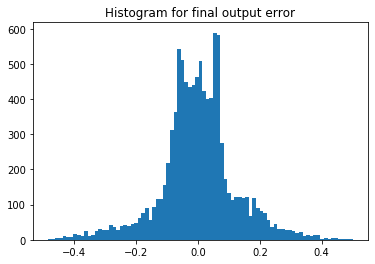

scnt: Parameter containing:
tensor([16.], device='cuda:0')
--- 0.4530010223388672 seconds ---
dividend error:  tensor(-0.0039, device='cuda:0') tensor(0.0039, device='cuda:0')
divisor  error:  tensor(-0.0078, device='cuda:0') tensor(0.0039, device='cuda:0')
quotient error:  tensor(-1.9492, device='cuda:0') tensor(1.8867, device='cuda:0')
dividend: tensor([[-0.0228,  0.0827, -0.0850,  ...,  0.0020, -0.4140,  0.1797]],
       device='cuda:0')
divisor: tensor([[-0.8320, -0.1680, -0.0938,  ..., -0.0312, -0.5195,  0.2422]],
       device='cuda:0')
quotient: tensor([[ 0.0273, -0.4922,  0.9062,  ..., -0.0625,  0.7969,  0.7422]],
       device='cuda:0')
scnt: Parameter containing:
tensor([[18., 31.,  7.,  ..., 16.,  2., 28.]], device='cuda:0')
RMSE 0.912063519323764
MAE 0.6787883
bias 0.0048375


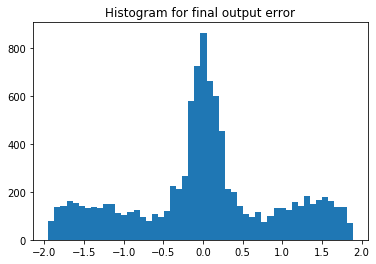

In [4]:
col = 10000
modes = ["unipolar", "bipolar"]
static = True
bitwidth = 8
bstype = torch.float
randtype = torch.float

for mode in modes:
    if mode is "unipolar":
        quotient = torch.rand(1, col).mul(2**bitwidth).round().div(2**bitwidth).to(device)
        divisor = torch.rand(1, col).mul(2**bitwidth).round().div(2**bitwidth).to(device)
    elif mode is "bipolar":
        quotient = torch.rand(1, col).mul(2).sub(1).mul(2**bitwidth).round().div(2**bitwidth).to(device)
        divisor = torch.rand(1, col).mul(2).sub(1).mul(2**bitwidth).round().div(2**bitwidth).to(device)

    dut_div = GainesDiv(buf_dep=5, mode=mode, rng="Sobol", rng_dim=2, bstype=torch.float).to(device)

    dividend = torch.mul(quotient, divisor).to(device)

    quotientPE = ProgressiveError(quotient, mode=mode).to(device)

    dividendPE = ProgressiveError(dividend, mode=mode).to(device)
    dividendSRC = SourceGen(dividend, bitwidth, mode=mode, randtype=randtype)().to(device)
    dividendRNG = RNG(bitwidth, 1, rng, randtype)().to(device)
    dividendBS = BSGen(dividendSRC, dividendRNG, bstype).to(device)
    
    divisorPE  = ProgressiveError(divisor,  mode=mode).to(device)
    divisorSRC = SourceGen(divisor, bitwidth, mode=mode, randtype=randtype)().to(device)
    divisorRNG = RNG(bitwidth, 1, rng, randtype)().to(device)
    divisorBS = BSGen(divisorSRC, divisorRNG, bstype).to(device)

    with torch.no_grad():
        start_time = time.time()
        print("scnt:", dut_div.scnt)
        for i in range(2**bitwidth):
            dividend_bs = dividendBS(torch.tensor([i]))
            dividendPE.Monitor(dividend_bs)

            divisor_bs = divisorBS(torch.tensor([i]))
            divisorPE.Monitor(divisor_bs)
            
            quotient_bs = dut_div(dividend_bs, divisor_bs)   
            quotientPE.Monitor(quotient_bs)
        print("--- %s seconds ---" % (time.time() - start_time))
        print("dividend error: ", torch.min(dividendPE()[1]), torch.max(dividendPE()[1]))
        print("divisor  error: ", torch.min(divisorPE()[1]), torch.max(divisorPE()[1]))
        
        print("quotient error: ", torch.min(quotientPE()[1]), torch.max(quotientPE()[1]))
        
        print("dividend:", dividend)
        print("divisor:", divisor)
        print("quotient:", quotient)

        print("scnt:", dut_div.scnt)
        
        result_pe = quotientPE()[1].view(-1).cpu().numpy()
        print("RMSE", math.sqrt(sum(result_pe**2)/len(result_pe)))
        print("MAE", np.mean(np.abs(result_pe)))
        print("bias", np.mean(result_pe))
        fig = plt.hist(result_pe, bins='auto')  # arguments are passed to np.histogram
        plt.title("Histogram for final output error")
        plt.show()